### The goal of this notebook is to explore modifcations to LAISS.

In [1]:
# Install packages
# !pip install numpy pandas pillow astropy matplotlib scikit-learn
# !pip install astro_ghost
# !pip install timeout_decorator
# !pip install gdown
# !pip install confluent-kafka
# !pip install annoy
# !pip install light-curve
# !pip install antares_client

# Download and unpack data
# !gdown -O ../ 131frC1TmAUenZewuHuY2wuOpXLyUji0m
# !unzip -o ../data.zip -d ../

In [2]:
import os

# a silly hack to switch the working directory to the one where this file is located
working_dir = os.path.abspath("")

import time
import datetime
import math
import numpy as np
import pandas as pd
import sys
import astro_ghost
import os
import subprocess

os.chdir(working_dir)
sys.path.append('../code/')

from helper_functions import *
from laiss_functions import *
from mod_helper_functions import *
from mod_laiss_functions import *

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")


## Run LAISS

In [3]:
# Set up file structure for the GHOST code that associates transients with their host galaxies.
host_path = "../data/host_info"
if not os.path.exists(host_path):
    os.makedirs(host_path)

os.environ['GHOST_PATH'] = host_path
getGHOST(real=False,verbose=False) # Using dummy host-galaxy association database

GHOST database already exists in the install path!


In [4]:
# Choose LAISS features to use
with open("../data/host_features.txt") as host_f:
    host_features = [line.strip() for line in host_f.readlines()]


with open("../data/lc_features.txt") as lc_f:
    lc_features = [line.strip() for line in lc_f.readlines()]

lc_and_host_features = host_features + lc_features

In [5]:
# Run PCA on light curve and host features to build space of 60 features and build ANNOY index on them
build_indexed_sample(fn='../data/dataset_bank_orig_5472objs.csv.gz', lc_features=lc_features, host_features=host_features, pca=True, save=True)

Loading previously saved ANNOY index


Run main function, `LAISS`. Arguments are:
* `l_or_ztfid_ref`: The ANTARES or ZTF name for the transient to query. By default, the photometry is retrieved as the first step in the pipeline.
* `lc_features`: The light curve features used in the similarity search. 
* `host_features`: The host-galaxy features used in the similarity search.
* `n`: The number of neighbors to retrieve using ANNOY.
* `use_lc_for_ann_only_bool`: Only uses photometry for the similarity search. This could easily be removed!
* `use_ysepz_phot_snana_file`: Instead of retrieving photometry from the ANTARES website, it can be supplied manually in the `timeseries` folder. 
* `show_lightcurves_grid` and `show_hosts_grid`: Shows the neighbors matched to the queried supernova. 
* `run_AD_model`: Additionally runs the random forest classifier to determine an anomaly score of the event at each observation. This requires both light curve and galaxy features to be calculated!
* `savetables`: Saves the intermediate data from the run.
* `savefigs`: Saves the generated figures. 
*  `ad_params`: The parameters of the specific anomaly detection classifier to load (these will always stay the same, unless we re-train the classifier). 

Running LAISS...
ZTF21aaublej is in dataset_bank
Loading previously saved ANNOY LC+HOST PCA=60 index
../data/dataset_bank_orig_5472objs_pcaTrue_hostTrue_annoy_index.ann
					   ZTFID IAU_NAME SPEC Z
REF. : https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
ANN=1: https://alerce.online/object/ZTF21abbkefe 2021mid SN Ia, 0.041542
ANN=2: https://alerce.online/object/ZTF21aafgljq 2021ars SN Ia, 0.05
ANN=3: https://alerce.online/object/ZTF20abqaqgv 2020qqn SN Ia, 0.045
ANN=4: https://alerce.online/object/ZTF21absvlrr 2021vtq SN Ia, 0.0208
ANN=5: https://alerce.online/object/ZTF20acucbek 2020abcl SN Ia, 0.03889
ANN=6: https://alerce.online/object/ZTF20aczgoml 2020adis SN Ia-91T-like, 0.0453189984
ANN=7: https://alerce.online/object/ZTF21abrxoir 2021vju SN Ia, 0.026657
ANN=8: https://alerce.online/object/ZTF21abqsysj 2021vpv SN Ia-91T-like, 0.04

ANN elapsed_time = 0.198 s

total elapsed_time = 7.059 s

Making a plot of stacked lightcurves...


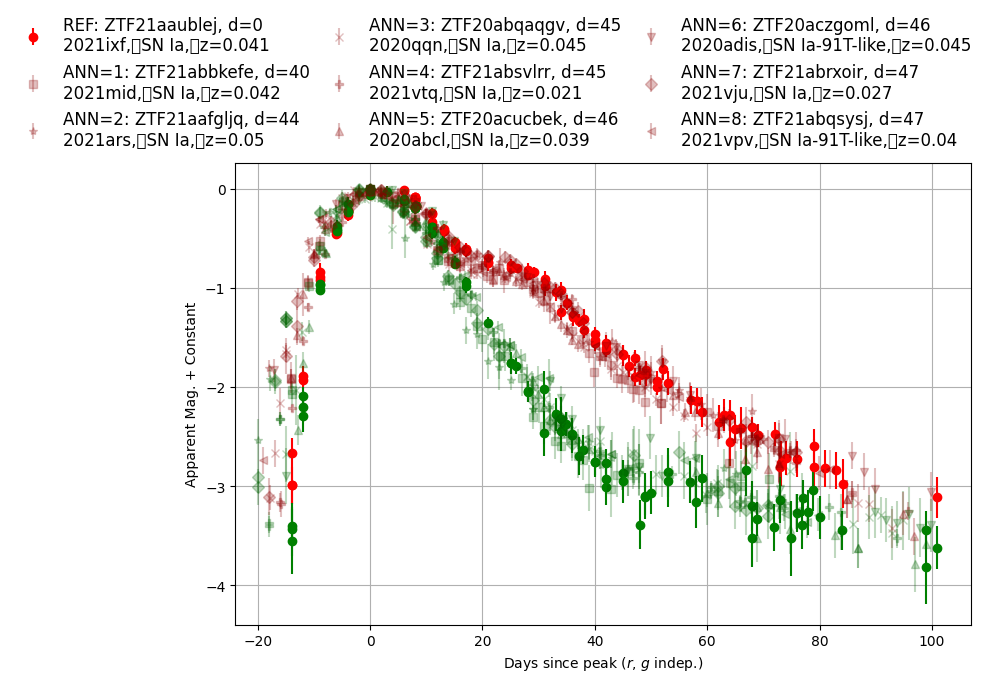


Running AD Model!...
Needs re-extraction for full timeseries.
Checking if made before...
Re-extracting LC+HOST features
Extracted LC features for ZTF21aaublej!
Extracted LC features in 1.01s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.60481288+37.00892855&filter=color
Saved results for ZTF21aaublej!

HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.60481288+37.00892855&filter=color

Prediction doesn't exceed anom_threshold of 50% for ZTF21aaublej.
max_anom_score 40.0
num_anom_epochs 0


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF21aaublej


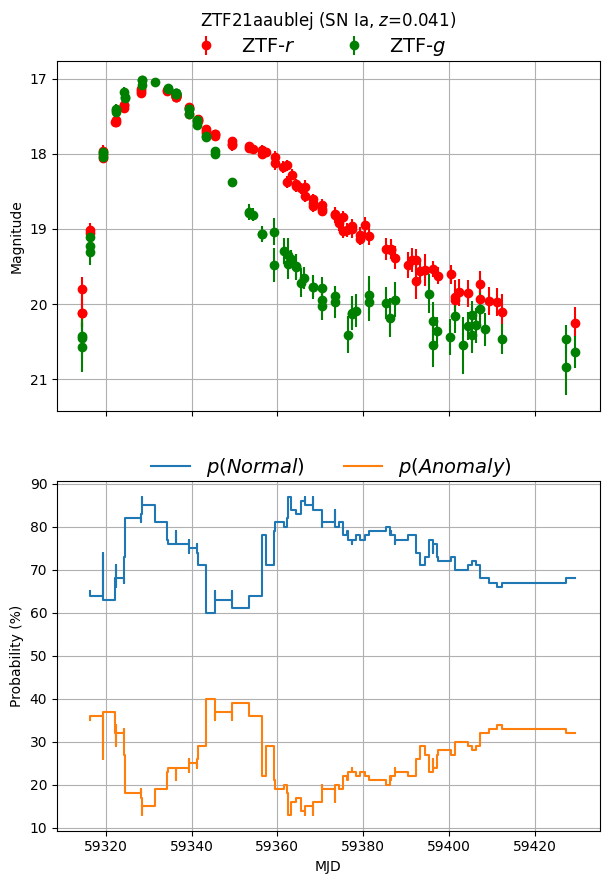

In [9]:
n_estimators = 100
max_depth = 35
random_state = 11
max_features = 35

# LAISS(l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej
#       lc_features=lc_features,
#       host_features=host_features,
#       n=8,
#       use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
#       use_ysepz_phot_snana_file=False,
#       show_lightcurves_grid=True,
#       show_hosts_grid=False, # host galaxy images currently don't display properly
#       run_AD_model=True, # needs host features for anomaly detection model
#       savetables=False,
#       savefigs=False, 
#      ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})

mod_LAISS(LC_l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej
      HOST_l_or_ztfid_ref="ZTF24aahxokj",
      lc_features=lc_features,
      host_features=host_features,
      n=8,
      use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
      use_ysepz_phot_snana_file=False,
      show_lightcurves_grid=True,
      show_hosts_grid=False, # host galaxy images currently don't display properly
      run_AD_model=True, # needs host features for anomaly detection model, but currently should use host and lc from LC transient
      savetables=False,
      savefigs=False, 
     ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})

## Bolometric Luminosity / Magnitude Curve

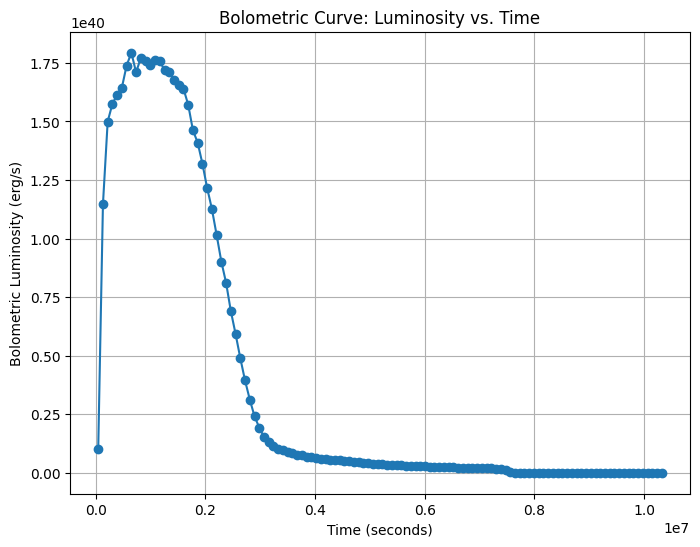

In [7]:
def plot_bolometric_curve(filename, magnitude=False):
    data = np.loadtxt(filename, skiprows=1)
    
    # Extract columns for time, wavelength, and luminosity density
    times = data[:, 0]
    wavelengths = data[:, 1]
    llam = data[:, 2]

    unique_times = np.unique(times)

    # Sum luminosity density over wavelengths for each time step
    bolometric_luminosity = []
    for time in unique_times:
        total_luminosity = llam[times == time].sum()
        bolometric_luminosity.append(total_luminosity)
    
    # If magnitude=True, convert bolometric luminosity to absolute magnitude
    if magnitude:
        L0 = 3.828e33  # Reference luminosity (erg/s)
        bolometric_magnitude = [-2.5 * np.log10(L / L0) for L in bolometric_luminosity]

    plt.figure(figsize=(8, 6))
    
    if magnitude:
        plt.plot(unique_times, bolometric_magnitude, marker='o', linestyle='-')
        plt.ylabel('Absolute Magnitude')
        plt.title('Bolometric Curve: Magnitude vs. Time')
    else:
        plt.plot(unique_times, bolometric_luminosity, marker='o', linestyle='-')
        plt.ylabel('Bolometric Luminosity (erg/s)')
        plt.title('Bolometric Curve: Luminosity vs. Time')

    plt.xlabel('Time (seconds)')
    plt.grid(True)
    plt.show()

    if magnitude:
        return np.array(bolometric_magnitude)
    else:
        return np.array(bolometric_luminosity)

bolometric_curve = plot_bolometric_curve("../data/sed_m60.0_mrp5.57_m560.000.dat", magnitude=False)


## Print LAISS Features

In [8]:
print(f"Number of lc features: {len(lc_features)}")
print(f"LIGHTCURVE FEATURES:")
print("\n".join(lc_features))
print("\n")

print(f"Number of host features: {len(host_features)}")
print(f"HOST FEATURES:")
print("\n".join(host_features))

Number of lc features: 62
LIGHTCURVE FEATURES:
feature_amplitude_magn_r
feature_anderson_darling_normal_magn_r
feature_beyond_1_std_magn_r
feature_beyond_2_std_magn_r
feature_cusum_magn_r
feature_inter_percentile_range_2_magn_r
feature_inter_percentile_range_10_magn_r
feature_inter_percentile_range_25_magn_r
feature_kurtosis_magn_r
feature_linear_fit_slope_magn_r
feature_linear_fit_slope_sigma_magn_r
feature_magnitude_percentage_ratio_40_5_magn_r
feature_magnitude_percentage_ratio_20_5_magn_r
feature_mean_magn_r
feature_median_absolute_deviation_magn_r
feature_percent_amplitude_magn_r
feature_median_buffer_range_percentage_10_magn_r
feature_median_buffer_range_percentage_20_magn_r
feature_percent_difference_magnitude_percentile_5_magn_r
feature_percent_difference_magnitude_percentile_10_magn_r
feature_skew_magn_r
feature_standard_deviation_magn_r
feature_stetson_k_magn_r
feature_weighted_mean_magn_r
feature_anderson_darling_normal_flux_r
feature_cusum_flux_r
feature_excess_variance_flu